# 0) 라이브러리 버전 확인

In [1]:
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2

# 3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [54]:
import tensorflow as tf
from tensorflow import keras

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


# 4) 모델 구성 및 validation set 구성

## validation set 구성

In [11]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 96182건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## RNN

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 8ms/step - loss: 0.6601 - accuracy: 0.5698 - val_loss: 0.4682 - val_accuracy: 0.8103
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3882 - accuracy: 0.8367 - val_loss: 0.3602 - val_accuracy: 0.8449
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.8611 - val_loss: 0.3568 - val_accuracy: 0.8449
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3141 - accuracy: 0.8677 - val_loss: 0.3528 - val_accuracy: 0.8463
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3035 - accuracy: 0.8737 - val_loss: 0.3552 - val_accuracy: 0.8453
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2952 - accuracy: 0.8775 - val_loss: 0.3634 - val_accuracy: 0.8448
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2892 - accuracy: 0.8795 - val_loss: 0.3697 - val_accuracy: 0.8414
Epoch 

In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5014 - accuracy: 0.8201
[0.5013724565505981, 0.820086658000946]


In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


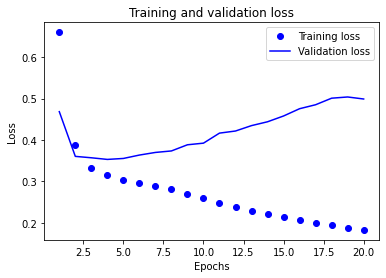

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

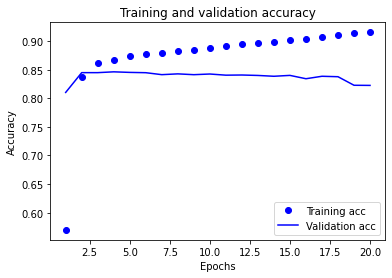

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D CNN

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 7ms/step - loss: 0.5233 - accuracy: 0.7311 - val_loss: 0.3646 - val_accuracy: 0.8395
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3357 - accuracy: 0.8560 - val_loss: 0.3437 - val_accuracy: 0.8499
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2990 - accuracy: 0.8756 - val_loss: 0.3442 - val_accuracy: 0.8513
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2724 - accuracy: 0.8889 - val_loss: 0.3524 - val_accuracy: 0.8501
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2446 - accuracy: 0.9033 - val_loss: 0.3651 - val_accuracy: 0.8484
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2138 - accuracy: 0.9181 - val_loss: 0.3840 - val_accuracy: 0.8437
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.1824 - accuracy: 0.9328 - val_loss: 0.4191 - val_accuracy: 0.8405
Epoch 

In [20]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0499 - accuracy: 0.8127
[1.0499141216278076, 0.8127428293228149]


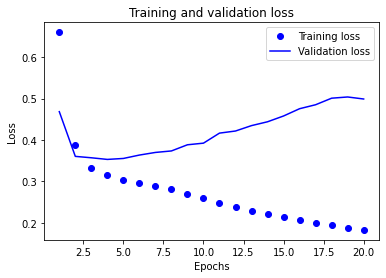

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

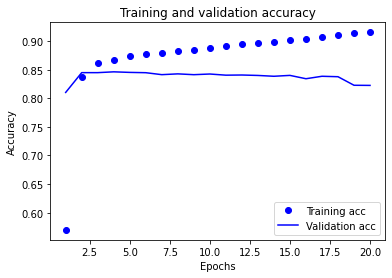

In [22]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling1D

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 1s 4ms/step - loss: 0.6074 - accuracy: 0.7494 - val_loss: 0.4703 - val_accuracy: 0.8125
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3969 - accuracy: 0.8335 - val_loss: 0.3708 - val_accuracy: 0.8355
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3339 - accuracy: 0.8587 - val_loss: 0.3559 - val_accuracy: 0.8426
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3017 - accuracy: 0.8754 - val_loss: 0.3546 - val_accuracy: 0.8456
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2780 - accuracy: 0.8871 - val_loss: 0.3577 - val_accuracy: 0.8459
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2590 - accuracy: 0.8967 - val_loss: 0.3651 - val_accuracy: 0.8448
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9036 - val_loss: 0.3742 - val_accuracy: 0.8425
Epoch 

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5690 - accuracy: 0.8186
[0.569024384021759, 0.8186016082763672]


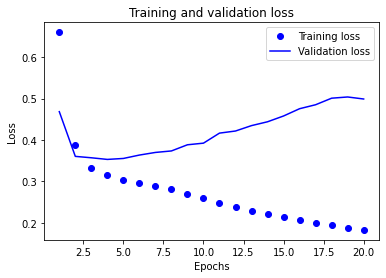

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

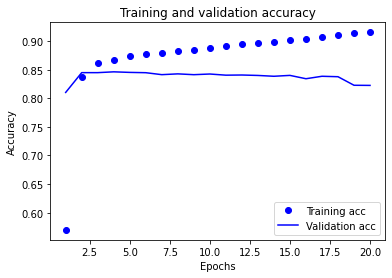

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 8) Word2Vec

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## 유사단어 찾기 활용 - 자체학습

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary =False)
vector = word_vectors['영화']
vector

array([-0.20647545, -0.26257968, -0.19907652, -0.24484156,  0.18805546,
       -0.23083988, -0.2552949 , -0.17436592, -0.27744043, -0.21379375,
       -0.1983613 , -0.23906757, -0.19518906, -0.21488129, -0.25659266,
       -0.21953447], dtype=float32)

In [33]:
word_vectors.similar_by_word('영화')

[('.', 0.9858620166778564),
 ('다', 0.9830264449119568),
 ('음', 0.9794443845748901),
 ('너무', 0.9765841960906982),
 ('스럽', 0.971136748790741),
 ('하', 0.9657515287399292),
 ('웹툰', 0.9625353813171387),
 ('매번', 0.9612272381782532),
 ('고', 0.9544894099235535),
 ('여서', 0.9522830843925476)]

## 유사단어 찾기 활용 - 사전학습

In [35]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [36]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_path)
vector = word2vec.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [38]:
word2vec.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [39]:
vector.shape

(100,)

In [41]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_metrix 에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
  if index_to_word[i] in word2vec.wv:
    embedding_matrix[i] = word2vec.wv[index_to_word[i]]

## RNN

In [42]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [48]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 2s 7ms/step - loss: 0.1198 - accuracy: 0.9601 - val_loss: 0.5942 - val_accuracy: 0.8294
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.1117 - accuracy: 0.9635 - val_loss: 0.6058 - val_accuracy: 0.8281
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 0.1080 - accuracy: 0.9643 - val_loss: 0.6365 - val_accuracy: 0.8271
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1032 - accuracy: 0.9663 - val_loss: 0.6547 - val_accuracy: 0.8270
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 0.0957 - accuracy: 0.9693 - val_loss: 0.6777 - val_accuracy: 0.8275


In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6971 - accuracy: 0.8223
[0.6971064805984497, 0.8223243951797485]


## 1-D CNN

In [50]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(4))
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 38, 16)            6416      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 16)             1040      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 2s 7ms/step - loss: 0.6579 - accuracy: 0.6221 - val_loss: 0.5628 - val_accuracy: 0.7121
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.5209 - accuracy: 0.7440 - val_loss: 0.4931 - val_accuracy: 0.7648
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4571 - accuracy: 0.7884 - val_loss: 0.4453 - val_accuracy: 0.7942
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4116 - accuracy: 0.8142 - val_loss: 0.4217 - val_accuracy: 0.8096
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3782 - accuracy: 0.8338 - val_loss: 0.3987 - val_accuracy: 0.8216
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3545 - accuracy: 0.8454 - val_loss: 0.3927 - val_accuracy: 0.8249
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3323 - accuracy: 0.8581 - val_loss: 0.3832 - val_accuracy: 0.8313
Epoch 

In [52]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.3836 - accuracy: 0.8357
[0.3835502564907074, 0.8357304334640503]


## GlobalMaxPooling1D

In [55]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 1s 5ms/step - loss: 0.7343 - accuracy: 0.5885 - val_loss: 0.6346 - val_accuracy: 0.6457
Epoch 2/10
188/188 [==============================] - 1s 4ms/step - loss: 0.6153 - accuracy: 0.6640 - val_loss: 0.5931 - val_accuracy: 0.6838
Epoch 3/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5862 - accuracy: 0.6899 - val_loss: 0.5714 - val_accuracy: 0.7033
Epoch 4/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5634 - accuracy: 0.7080 - val_loss: 0.5596 - val_accuracy: 0.7126
Epoch 5/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5412 - accuracy: 0.7260 - val_loss: 0.5386 - val_accuracy: 0.7268
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5246 - accuracy: 0.7377 - val_loss: 0.5220 - val_accuracy: 0.7397
Epoch 7/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5078 - accuracy: 0.7504 - val_loss: 0.5099 - val_accuracy: 0.7476
Epoch 

In [57]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.4861 - accuracy: 0.7636
[0.4861374795436859, 0.7635942101478577]
